In [1]:
from circuit_knitting.cutting import partition_problem
from qiskit.circuit import QuantumCircuit, ParameterVector
# from quantum_image_processing.neural_networks import QCNN
# from quantum_image_processing.neural_networks.layers import QuantumConvolutionalLayer, QuantumPoolingLayer2, FullyConnectedLayer
from qiskit.quantum_info import SparsePauliOp, PauliList
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from qiskit.visualization import circuit_drawer
from qiskit_machine_learning.neural_networks.estimator_qnn import EstimatorQNN
from qiskit_machine_learning.neural_networks.sampler_qnn import SamplerQNN
# from quantum_image_processing.data_loader.mnist_data_loader import load_mnist_data
# from quantum_image_processing.data_encoder.angle_encoder import angle_encoding
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_algorithms.optimizers.cobyla import COBYLA
from qiskit.algorithms.optimizers import ADAM, SPSA
from qiskit_algorithms.utils import algorithm_globals
from IPython.display import clear_output

/var/folders/3j/3p_dzlvs1nsdfryf9hm7gjnr0000gn/T/ipykernel_79391/4111609774.py:17: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed in Qiskit 1.0. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import ADAM, SPSA


In [2]:
seed = 100

## Data Loading

In [3]:
# Load data
data = pd.read_csv("diabetes_normalized.csv")
data = data.drop(["Unnamed: 0"], axis=1)
# data = data.drop(["BMI", "SkinThickness", "Pregnancies"], axis=1)
data.head(2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,-0.923998,1.531329,0.566517,-0.920265,-3.141593,0.004682,-1.66872,-0.104720,1
1,-2.771994,-0.457820,0.257508,-1.301064,-3.141593,-0.650792,-2.40918,-2.094395,0


In [4]:
y = data["Outcome"]
x = data.drop(["Outcome"], axis=1)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(537, 8) (537,) (231, 8) (231,)


In [6]:
x_train_A = x_train.iloc[:, :4]
x_train_B = x_train.iloc[:, 4:]
# x_train.iloc[:, 4:]

In [7]:
x_test_A = x_test.iloc[:, :4]
x_test_B = x_test.iloc[:, 4:]

In [8]:
# y_train

## Data Embedding

In [9]:
# Data Embedding - Angle Encoding
def angle_encoding(feature_dims: int):
    embedding = QuantumCircuit(feature_dims)
    feature_param = ParameterVector("Theta", feature_dims)
    for qubit in range(feature_dims):
        embedding.ry(feature_param[qubit], qubit)
    return embedding, feature_param

In [10]:
embedding, feature_params = angle_encoding(4)

## Tensor Network

In [11]:
from ttn import TTN

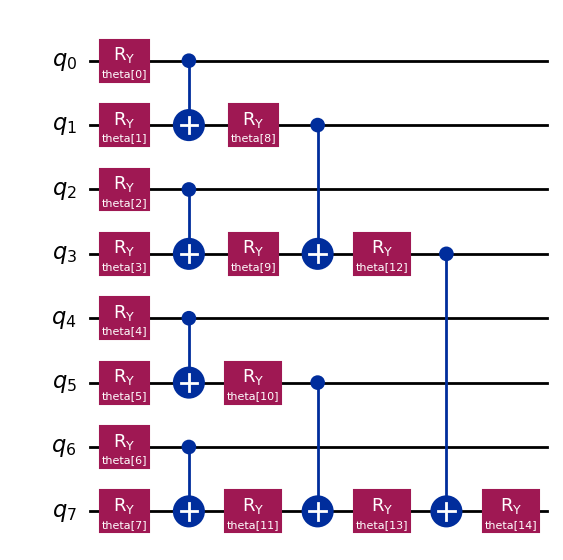

In [12]:
ttn = TTN(num_qubits=8).ttn_simple(complex_structure=False)
ttn.draw("mpl", style="iqp")

In [13]:
# ttn.parameters

## Circuit Cutting

In [ ]:
observables = PauliList(["ZIIIIIII"])
partitioned_problem = partition_problem(circuit=ttn, partition_labels="AAAABBBB", observables=observables)
sub_circuits = partitioned_problem.subcircuits
sub_observables = partitioned_problem.subobservables
bases = partitioned_problem.bases

In [ ]:
sub_observables

In [ ]:
sub_circuits["A"].draw("mpl", style="iqp")

In [ ]:
sub_circuits["B"].draw("mpl", style="iqp")

In [ ]:
print(f"Sampling overhead: {np.prod([basis.overhead for basis in bases])}")

### Sub Experiments

In [ ]:
from circuit_knitting.cutting import generate_cutting_experiments

subexperiments, coefficients = generate_cutting_experiments(
    circuits=sub_circuits, observables=sub_observables, num_samples=np.inf
)

In [ ]:
# subexperiments
len(subexperiments["A"])

In [ ]:
subexperiments["A"][0].draw("mpl", style="iqp")

In [ ]:
subexperiments["B"][3].draw("mpl", style="iqp")

## Neural Network Training

In [ ]:
from qiskit_machine_learning.neural_networks import SamplerQNN, NeuralNetwork
from qiskit_aer.primitives import Sampler
from typing import Callable

### Sampler

In [ ]:
from custom_sampler_qnn import CustomSampler

#### For subexperiments["A"]

In [ ]:
final_circuits = [embedding.compose(subex_circuit, inplace=False) for subex_circuit in subexperiments["A"]]
# final_circuits[0].draw("mpl")

In [ ]:
sampler_qcnn = CustomSampler(
    circuits=final_circuits, 
    input_params=feature_params.params,
    weight_params=sub_circuits["A"].parameters,
    # output_shape=4,
    input_gradients=False,
)

In [ ]:
weights_A = algorithm_globals.random.random(7)
# forward_output, forward_sampler_result

forward_output = sampler_qcnn.forward(
    input_data=x_train_A,
    weights=weights_A,
)

In [ ]:
# forward output is a dictionary of 6 subex_circ items.
print(f"Output shape for {len(x_train_A)} samples: {forward_output[0].shape}")
print(len(forward_output[0]))
print(f"Output of the forward pass for first sample: \n{np.array([forward_output[i][0] for i in range(6)])}")

In [ ]:
# OLD
# forward_output_quasi_dists = {
#     index: result.quasi_dists 
#     for index, result in forward_output.items()
# }

# print("Forward output", forward_output)
# print(forward_output_quasi_dists[0][0])
# print(f"Total results for per sample: {len(forward_output_quasi_dists)}")
# print(f"Total samples: {len(forward_output_quasi_dists[0])}")

In [ ]:
input_grad, weights_grad = sampler_qcnn.backward(
    input_data=x_train_A,
    weights=weights_A
)

In [ ]:
print(f"Output shape for {len(x_train_A)} samples: {weights_grad[0].shape}")
print(f"Output of the backward pass for first sample for first subexperiment circuit: \n{np.array([weights_grad[i][0] for i in range(6)])}")

In [ ]:
# OLD
# backward_output_gradients = {
#     index: result.gradients 
#     for index, result in backward_output.items()
# }
# backward_output_gradients

# Gradients per parameter value
# print(f"Gradients of {len(backward_output_gradients[0][0])} parameters are: {backward_output_gradients[0][0]}")
# print(f"Total results for per sample: {len(backward_output_gradients)}")
# print(f"Total samples: {len(backward_output_gradients[0])}")

#### For subexperiments["B"]

In [ ]:
final_circuits2 = [embedding.compose(subex_circuit, inplace=False) for subex_circuit in subexperiments["B"]]

In [ ]:
sampler_qcnn2 = CustomSampler(
    circuits=final_circuits2, 
    input_params=feature_params.params,
    weight_params=sub_circuits["B"].parameters,
)

In [ ]:
weights_B = algorithm_globals.random.random(8)
forward_output2 = sampler_qcnn2._forward(
    input_data=x_train_B,
    weights=weights_B,
)

In [ ]:
print(f"Output shape for {len(x_train_A)} samples: {forward_output2[0].shape}")
print(len(forward_output2[0]))
print(f"Output of the forward pass for first sample: \n{np.array([forward_output2[i][0] for i in range(6)])}")

In [ ]:
input_grad2, weights_grad2 = sampler_qcnn2._backward(
    input_data=x_train_B,
    weights=weights_B
)

In [ ]:
print(f"Output shape for {len(x_train_B)} samples: {weights_grad2[0].shape}")
print(f"Output of the backward pass for first sample for first subexperiment circuit: \n{np.array([weights_grad2[i][0] for i in range(6)])}")

## Loss and Optimization

In [ ]:
from qiskit_machine_learning.utils.loss_functions import L2Loss
from qiskit_algorithms.optimizers import COBYLA, SPSA, GradientDescent
# from custom_SPSA import CustomSPSA
from objective_func import CustomMultiClassObjectiveFunction
from optimization import create_objective, minimizer, print_optimizer_results

In [ ]:
def callback(nfev=None, params=None, fval=None, stepsize=None, accepted=None):
    """
    nfev: the number of function evals
    params: the current parameters
    fval: the current function value
    stepsize: size of the update step
    accepted: whether the step was accepted (not used for )
    """
    global objective_func_vals

    if (nfev % 3) == 0:
        objective_func_vals.append(fval)
        print(f"SPSA Epoch {len(objective_func_vals)}: {fval:.5f}")

In [ ]:
objective_func_vals = []
loss = L2Loss()
# optimizer = COBYLA(maxiter=10)
optimizer = SPSA(maxiter=10, callback=callback)
# optimizer = GradientDescent(maxiter=2) # This doesn't work yet. The gradient shape doesn't match.

# Reshape the array into shape (537, 6, 16)
# new_y_train = np.tile(y_train, 6 * 16)
# print(y_train.shape, new_y_train.shape)

#### Optimizer Result for sub-circuits["A"]

In [ ]:
# objective = create_objective(x_train_A, y_train, sampler_qcnn, loss)
initial_point = np.random.random((7,))
function = CustomMultiClassObjectiveFunction(x_train_A, y_train, sampler_qcnn, loss)

In [ ]:
# function.objective0(initial_point)

In [ ]:
# function.gradient0(initial_point)

In [ ]:
# Optimizer result for 0th circuit for sub-circuit-A
optimizer_result_A0 = minimizer(function, function.objective0, function.gradient0, initial_point, optimizer)
optimizer_result_A1 = minimizer(function, function.objective1, function.gradient1, initial_point, optimizer)
optimizer_result_A2 = minimizer(function, function.objective2, function.gradient2, initial_point, optimizer)
optimizer_result_A3 = minimizer(function, function.objective3, function.gradient3, initial_point, optimizer)
optimizer_result_A4 = minimizer(function, function.objective4, function.gradient4, initial_point, optimizer)
optimizer_result_A5 = minimizer(function, function.objective5, function.gradient5, initial_point, optimizer)

In [ ]:
optimizer_results_A = [optimizer_result_A0, optimizer_result_A1, optimizer_result_A2, optimizer_result_A3, optimizer_result_A4, optimizer_result_A5]

In [ ]:
# Print results from 6 sub-experiments of sub-circuit-A
for opt_result in optimizer_results_A:
    print_optimizer_results(opt_result)

In [ ]:
plt.plot(objective_func_vals[:10], label="A Subex-1")
plt.plot(objective_func_vals[10:20], label="A Subex-2")
plt.plot(objective_func_vals[20:30], label="A Subex-3")
plt.plot(objective_func_vals[30:40], label="A Subex-4")
plt.plot(objective_func_vals[40:50], label="A Subex-5")
plt.plot(objective_func_vals[50:60], label="A Subex-6")
plt.legend()
plt.xlabel("Number of epochs")
plt.title("Training loss")

In [ ]:
objective_func_vals.clear()
objective_func_vals

#### Optimizer Result for sub-circuits["B"]

In [ ]:
initial_point2 = np.random.random((8,))
function2 = CustomMultiClassObjectiveFunction(x_train_B, y_train, sampler_qcnn2, loss)

In [ ]:
# Optimizer result for 0th circuit for sub-circuit-B
optimizer_result_B0 = minimizer(function2, function2.objective0, function2.gradient0, initial_point2, optimizer)
optimizer_result_B1 = minimizer(function2, function2.objective1, function2.gradient1, initial_point2, optimizer)
optimizer_result_B2 = minimizer(function2, function2.objective2, function2.gradient2, initial_point2, optimizer)
optimizer_result_B3 = minimizer(function2, function2.objective3, function2.gradient3, initial_point2, optimizer)
optimizer_result_B4 = minimizer(function2, function2.objective4, function2.gradient4, initial_point2, optimizer)
optimizer_result_B5 = minimizer(function2, function2.objective5, function2.gradient5, initial_point2, optimizer)

In [ ]:
optimizer_results_B = [optimizer_result_B0, optimizer_result_B1, optimizer_result_B2, optimizer_result_B3, optimizer_result_B4, optimizer_result_B5]

In [ ]:
# Print results from 6 sub-experiments of sub-circuit-B
for opt_result in optimizer_results_B:
    print_optimizer_results(opt_result)

In [ ]:
plt.plot(objective_func_vals[:10], label="B Subex1")
plt.plot(objective_func_vals[10:20], label="B Subex2")
plt.plot(objective_func_vals[20:30], label="B Subex3")
plt.plot(objective_func_vals[30:40], label="B Subex4")
plt.plot(objective_func_vals[40:50], label="B Subex5")
plt.plot(objective_func_vals[50:60], label="B Subex6")
plt.legend()
plt.xlabel("Number of epochs")
plt.title("Training loss")

In [ ]:
objective_func_vals.clear()
objective_func_vals

## Reconstruct Expectation Values

In [ ]:
from circuit_knitting.cutting import reconstruct_expectation_values

#### Testing for x_test[0]

In [ ]:
final_circuits = [embedding.compose(subex_circuit, inplace=False) for subex_circuit in subexperiments["A"]]

In [ ]:
final_circuits2 = [embedding.compose(subex_circuit, inplace=False) for subex_circuit in subexperiments["B"]]

In [ ]:
for index, result in enumerate(optimizer_results_A):
    param = np.append(x_test_A.values[13], result.x)
    final_circuits[index].assign_parameters(param, inplace=True)

In [ ]:
for index, result in enumerate(optimizer_results_B):
    param = np.append(x_test_B.values[13], result.x)
    # print(len(param))
    final_circuits2[index].assign_parameters(param, inplace=True)

In [ ]:
final_circs = {}
final_circs["A"] = final_circuits
final_circs["B"] = final_circuits2
final_circs

In [ ]:
# Missing: The embedding

samplers = {
    label: Sampler(run_options={"shots": 2**12}) for label in subexperiments.keys()
}

results = {
    label: sampler.run(final_circs[label]).result()
    for label, sampler in samplers.items()
}

In [ ]:
reconstructed_expvals = reconstruct_expectation_values(
    # combined_results_dict,
    results,
    coefficients,
    sub_observables,
)

In [ ]:
reconstructed_expvals

In [ ]:
# predict_sampler = np.argmax(reconstructed_expvals, axis=1)
predict_estimator = np.sign(reconstructed_expvals)
predict_estimator

## Test original circuit for x_test[0]

In [14]:
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
from qiskit.primitives import BackendEstimator
from qiskit_aer import AerSimulator

In [15]:
embedding, features = angle_encoding(8)
new_ttn = TTN(num_qubits=8).ttn_simple(complex_structure=False)
org_circuit = embedding.compose(new_ttn)
# final_circuit.draw()

In [21]:
gpu_simulator = AerSimulator(device='GPU')
simulator = AerSimulator()
backend = BackendEstimator(backend=simulator)

In [22]:
observable = SparsePauliOp(["ZIIIIIII"])
estimator_qnn = EstimatorQNN(
    estimator=backend,
    circuit=org_circuit,
    observables=observable,
    input_params=features.params,
    weight_params=new_ttn.parameters,
)

In [23]:
weights = np.random.random(len(new_ttn.parameters))

In [24]:
# Forward pass
output = estimator_qnn.forward(x_train, weights)
print(f"Output shape for {len(x)} samples: {output.shape}")
print(f"Output of the forward pass for first sample: {output[0]}")

Output shape for 768 samples: (537, 1)
Output of the forward pass for first sample: [0.15820312]


In [ ]:
# Backward pass
_, weights_grad = estimator_qnn.backward(x_train, weights)
print(f"Output shape for {len(x)} samples: {weights_grad.shape}")
print(f"Output of the backward pass for first sample: {weights_grad[0]}")

In [ ]:
initial_point = np.random.random((len(new_ttn.parameters),))

In [ ]:
def encode_y(y):
    y_encoded = y.replace({0: -1, 1: 1})
    return y_encoded

new_y = encode_y(y_test)
new_y_train = encode_y(y_train)

In [ ]:
classifier = NeuralNetworkClassifier(
    estimator,
    optimizer=SPSA(maxiter=10, callback=callback),
    initial_point=initial_point,
)

In [ ]:
print(len(x_test.values), len(new_y.values))

In [ ]:
classifier.fit(x_train, new_y_train)

In [ ]:
plt.plot(objective_func_vals)
plt.xlabel("Number of epochs")
plt.title("Training loss")

In [ ]:
y_test_pred = classifier.predict(x_test.values[17])
y_test_pred

In [ ]:
import copy

empty_dict = {}
for num_samples in range(537):
    empty_dict[num_samples] = []

dists_dict = copy.deepcopy(empty_dict)
metadata_dict = copy.deepcopy(empty_dict)

for num_samples in range(537):
    for k, v in forward_sampler_result.items():
        # print(num_samples, k, v.quasi_dists[num_samples])
        dists_dict[num_samples].append(v.quasi_dists[num_samples])
        metadata_dict[num_samples].append(v.metadata[num_samples])

A_dict = copy.deepcopy(empty_dict)
for key, item in new_dict.items():
    A_dict[key] = SamplerResult(quasi_dists=dists_dict[key], metadata=metadata_dict[key])

print(len(dists_dict), len(metadata_dict[0]))
print(len(A_dict), len(A_dict[0].quasi_dists), len(A_dict[0].metadata))

In [ ]:
# B_dict

dists_dict = copy.deepcopy(empty_dict)
metadata_dict = copy.deepcopy(empty_dict)

for num_samples in range(537):
    for k, v in forward_sampler_result2.items():
        # print(num_samples, k, v.quasi_dists[num_samples])
        dists_dict[num_samples].append(v.quasi_dists[num_samples])
        metadata_dict[num_samples].append(v.metadata[num_samples])

B_dict = copy.deepcopy(empty_dict)
for key, item in new_dict.items():
    B_dict[key] = SamplerResult(quasi_dists=dists_dict[key], metadata=metadata_dict[key])

print(len(dists_dict), len(metadata_dict[0]))
print(len(B_dict), len(B_dict[0].quasi_dists), len(B_dict[0].metadata))

In [ ]:
# combine dicts
combine_dict = {"A": None, "B": None}
reconstructed_expvals = []

zip_dict = zip(A_dict.items(), B_dict.items())
# print(zip_dict)
for (num_subex1, v1), (num_subex2, v2) in zip_dict:
    # print((num_subex1, v1), (num_subex2, v2))
    combine_dict["A"] = v1
    combine_dict["B"] = v2
    reconstructed_expvals.append(
        reconstruct_expectation_values(
            combine_dict,
            coefficients,
            sub_observables,
        )[0]
    )

# print(combine_dict)

In [ ]:
# reconstructed_expvals = reconstruct_expectation_values(
#     results,
#     coefficients,
#     subobservables,
# )